# 447 Fall 2023 week 8

This is section 8 from the examples notebook, copied here because the full examples notebook is laggy when opened in JupyterHub.

## set up environment

The following are familiar:

In [44]:
# "magic" commands, prefaced with "%", changes settings in the notebook

# this ensures plots are embedded in notebook web page
%matplotlib inline

# pdb = Python debugger -- this command turns the debugger OFF
%pdb off

from _447 import *

Automatic pdb calling has been turned OFF


We need one more module: the [Control Systems Library](https://python-control.readthedocs.io/en/0.9.4/) called `python-control`. This one isn't installed by default on UW's JupyterHub instances, so we'll install it using the Python package installer [PyPI](https://pypi.org/project/pip/) called `pip`. 

(Putting a "bang" `!` at the beginning of a line of code causes what follows to be executed on the command line -- so an equivalent way to run the following would be to open up a terminal tab and enter `pip install control`.)

Due to the way UW's JupyterHub works, you'll need to re-run this command every time you log in to the server.

In [45]:
!pip install control

Since the preceding command didn't produce an error, we can proceed with importing the control module.

In [46]:
import control as ctrl

# 8 -- python-control

The [Python Control Systems Library](https://python-control.readthedocs.io/en/0.8.3/) (`python-control`) provides a suite of computational tools for working with linear systems:
* ***Representation:*** Linear input/output systems in state-space and frequency domain
* ***Block diagram algebra:*** serial, parallel, and feedback interconnections
* ***Time response:*** initial condition, step response, impulse response
* ***Frequency response:*** Bode and Nyquist plots
* ***Controller analysis:*** stability, reachability, observability, stability margins
* ***Controller design:*** eigenvalue placement, linear-quadratic regulator (LQR), robust controllers (H2, Hinf)
* ***Model reduction:*** balanced realizations, Hankel singular values
* ***Estimator design:*** linear quadratic estimator (Kalman filter)

Many of these tools are familiar -- let's see how they're used.

***Note:*** this free Python library replicates most functionality in the [Matlab Control System Toolbox](https://www.mathworks.com/products/control.html) -- in fact, both the Python library and the Matlab toolbox are built on the free and open-source Fortran library [SLICOT](http://slicot.org/); this situation is analogous to the fact that numerical linear algebra in Python and Matlab are both based on the free and open-source Fortran library [LAPACK](http://www.netlib.org/lapack/).  The main thing Matlab has going for it is [Simulink](https://en.wikipedia.org/wiki/Simulink), which is a block diagram GUI that has no Python substitute (for now!).

To install the toolbox, you'll need to switch to a command line interface (CLI). In JupyterHub, you can click the "+" next to the tab with the name of your current file at the top of the window, then scroll down and click the "Terminal" button in the "Other" section. After that, simply type `pip install control` and press enter. The installation should only take a few seconds to complete. To test it, come back to this notebook and evaluate the following cell -- if it runs without error, you have successfully installed the toolbox!

In [47]:
import control as ctrl

We'll use the following RLC circuit as our running example:
$$ (\text{DE})\quad L \ddot{q} + R \dot{q} + q/C = u $$
where $q$ denotes the charge on the capacitor,
($R$, $L$, $C$) denote the (resistor, inductor, capacitor) parameters,
and $u$ denotes a series voltage source.

Note that `python-control` does not work with symbolic expressions, so we'll need to work with a specific set of parameter values:

In [48]:
R,L,C = 1.,1.,1. # Ohm, Henry, Farad

## representation

The `python-control` library supports both transfer function and state-space representations of linear systems.

### transfer function

The transfer function corresponding to $\text{(DE)}$ is
$$ (\text{TF})\quad G(s) = \frac{1}{Ls^2 + R s + 1/C}. $$

In `python-control`, we'll specify this transfer function using the sequence of coefficients that multiply powers of $s$ in the numerator `num` and denominator `den` polynomials in descending order:

In [49]:
num = [1.]
den = [L,R,1/C]

tf = ctrl.TransferFunction(num,den)

print(tf)


     1
-----------
s^2 + s + 1



### state-space

Letting $x = (q,\dot{q})\in\mathbb{R}^2$ denote the state of the circuit, we can rewrite (DE) in linear state-space form as $\dot{x} = A x + B u$ where

$$ (\text{SS})\quad \dot{x} = \frac{d}{dt}\left[\begin{array}{c} q \\ \dot{q} \end{array}\right] = \left[\begin{array}{c} \dot{q} \\ (-R\dot{q} - q/C + u)/L \end{array}\right] = \left[ \begin{matrix} 0 & 1 \\ -1/LC & -R/L \end{matrix} \right]\left[ \begin{matrix} q \\ \dot{q} \end{matrix} \right] + \left[ \begin{matrix} 0 \\ 1/L \end{matrix} \right] u = A x + B u.$$

and the output equation $y = C x + D u = \left[\begin{matrix} 1 & 0 \end{matrix}\right] x + \left[\begin{matrix} 0 \end{matrix}\right]\, u$.

In [50]:
A = np.array([[0,1],[-1/(L*C),-R/L]])
B = np.array([[0],[1/L]])
C = np.array([[1,0]]) # NOTE: overwrites capacitance variable !!!
D = np.array([[0]])

ss = ctrl.StateSpace(A, B, C, D)

print(ss)

A = [[ 0.  1.]
     [-1. -1.]]

B = [[0.]
     [1.]]

C = [[1. 0.]]

D = [[0.]]



### state-space to/from transfer function

To pass back and forth between state-space and transfer function representations, use `ss2tf` and `tf2ss`:

In [51]:
ctrl.ss2tf(ss)

TransferFunction(array([1.]), array([1., 1., 1.]))

In [52]:
ctrl.tf2ss(tf)

StateSpace(array([[-1., -1.],
       [ 1.,  0.]]), array([[1.],
       [0.]]), array([[0., 1.]]), array([[0.]]))

***Note:*** state-space representations aren't unique, so it isn't surprising that the $A,B,C,D$ matrices I get back don't match the ones I started with.

## analysis

### phase portrait

If we specify the differential equation in the form $\dot{x} = f(x,t)$ then we can generate the phase portrait using `phase_plot`.

In [54]:
ctrl.phase_plot?

Signature:
ctrl.phase_plot(
    odefun,
    X=None,
    Y=None,
    scale=1,
    X0=None,
    T=None,
    lingrid=None,
    lintime=None,
    logtime=None,
    timepts=None,
    parms=(),
    verbose=True,
)
Docstring:
Phase plot for 2D dynamical systems

Produces a vector field or stream line plot for a planar system.

Call signatures:
  phase_plot(func, X, Y, ...) - display vector field on meshgrid
  phase_plot(func, X, Y, scale, ...) - scale arrows
  phase_plot(func. X0=(...), T=Tmax, ...) - display stream lines
  phase_plot(func, X, Y, X0=[...], T=Tmax, ...) - plot both
  phase_plot(func, X0=[...], T=Tmax, lingrid=N, ...) - plot both
  phase_plot(func, X0=[...], lintime=N, ...) - stream lines with arrows

Parameters
----------
func : callable(x, t, ...)
    Computes the time derivative of y (compatible with odeint).
    The function should be the same for as used for
    :mod:`scipy.integrate`.  Namely, it should be a function of the form
    dxdt = F(x, t) that accepts a state x o

(-1.0, 1.0)

/opt/conda/lib/python3.10/site-packages/matplotlib/quiver.py:646: RuntimeWarning: overflow encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))


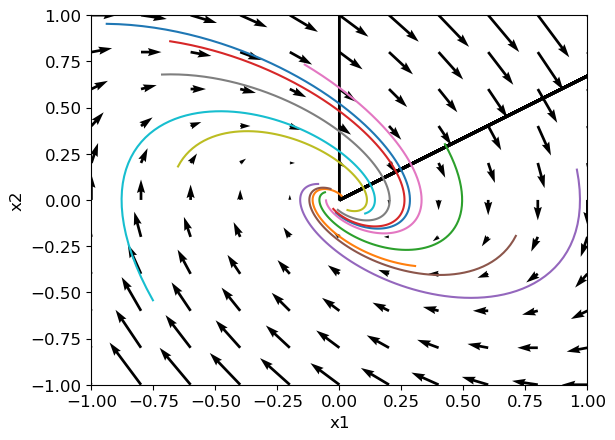

In [53]:
# note: arguments are in opposite order than numerical_simulation
def f(x,t):
  return np.dot(x,A.T)

# X and Y meshes for vector field
# [lower limit, upper limit, number of points]
X,Y = [-1,+1,11],[-1,+1,11]

# initial conditions for streamplots
X0 = 2*np.random.rand(10,2)-1

ctrl.phase_plot(f,X=X,Y=Y,X0=X0,T=5)
plt.xlim(-1,+1)
plt.ylim(-1,+1)

### impulse response

The `impulse_response` function generates the impulse response for a system in state-space or transfer function form:

Text(0, 0.5, 'output')

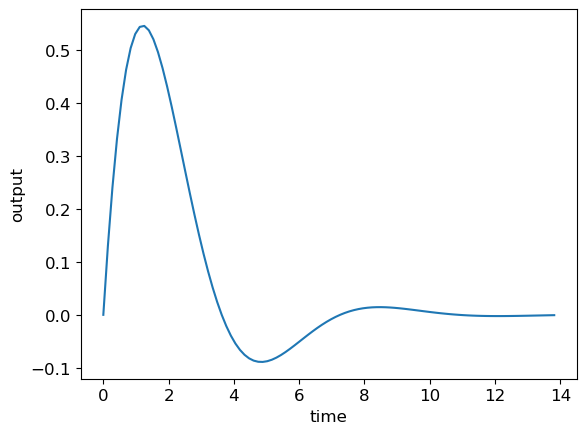

In [12]:
t,y = ctrl.impulse_response(ss)
#t,y = ctrl.impulse_response(tf) # <-- same result

plt.plot(t,y)
plt.xlabel('time')
plt.ylabel('output')

### step response

The `step_response` function generates the step response for a system in state-space or transfer function form:

Text(0, 0.5, 'output')

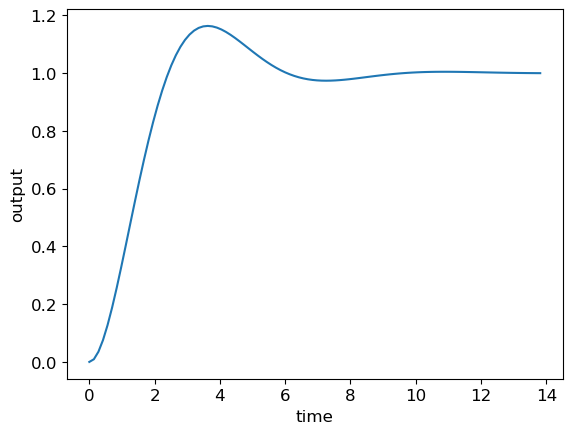

In [13]:
t,y = ctrl.step_response(ss)
#t,y = ctrl.step_response(tf) # <-- same result

plt.plot(t,y)
plt.xlabel('time')
plt.ylabel('output')

### frequency response

To evaluate the system's response to $\sin\omega t$, use `evalfr(sys,w)` where `sys` is `ss` or `tf` and `w` is $\omega$.

For instance, the DC gain is obtained by evaluating at `w=0.`:

In [14]:
ctrl.evalfr(ss,0.)

(1+0j)

There's also a `dcgain` function for determining this quantity specifically.

In [15]:
ctrl.dcgain(ss)

1.0

### Bode plot

The `bode_plot` function generates a Bode plot for a system in state-space or transfer function form:

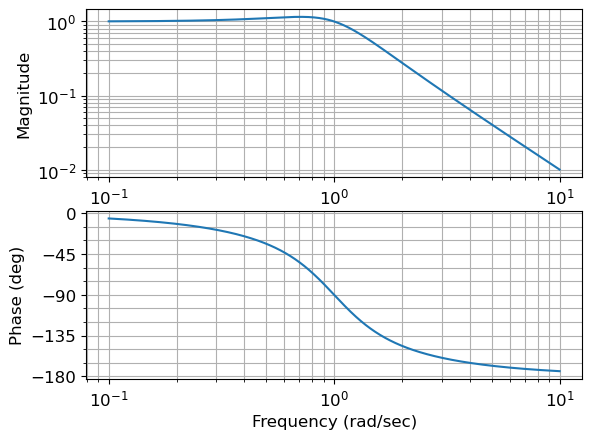

In [16]:
ctrl.bode_plot(ss);
# ctrl.bode_plot(tf); # <-- same thing

### poles and zeros

The poles and zeros (i.e. roots of the denominantor and numerator polynomials of the transfer function representation) can be computed using the `pole` and `zero` functions:

In [17]:
ctrl.pole(ss)

array([-0.5+0.866j, -0.5-0.866j])

In [18]:
ctrl.zero(ss)

array([], dtype=complex128)

### root locus

***Note:*** this routine only generates root locus plots as $k_P$ varies in $u = - k_P y$.

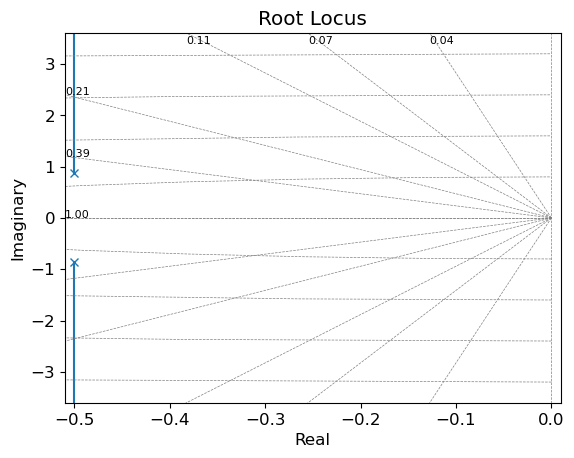

In [19]:
ctrl.root_locus(ss);

## nonlinear system

The `python-control` module is primarily designed to work with linear systems, but there are tools for extracting a linear system from a nonlinear system through linearization.

We'll apply these techniques to the inverted pendulum, which consists of a massless rod of length $\ell$ with a point mass $m$ affixed to one end and a rotational joint affixed to the other end,
$$
m \ell^2 \ddot{q} = m g \ell \sin q - \alpha\dot{q} + \ell u \cos q,
$$
where
$q$ is the pendulum angle,
$\alpha > 0$ is a coefficient of rotational friction,
and $u$ is the horizontal acceleration of the pivot point.

We'll assume we obtain nonlinear measurements of the pendulum angle,

$$ y = \ell\sin q. $$

In [55]:
# pendulum parameters
m = 1.    # kg
l = 0.5   # m
g = 9.81  # m / sec^2
a = .5

# \dot{x} = f(t,x,u,p)
def f(t,x,u,p):
  q,dq = x
  ddq = (m*g*l*np.sin(q) - a*dq + l*u*np.cos(q)) / (m*l**2)
  return np.hstack([dq,ddq])

# y = h(t,x,u,p)
def h(t,x,u,p):
  q,dq = x
  return np.hstack([l*np.sin(q)])

### representation

To create a nonlinear system object, we pass the $f$ and $h$ functions defined above into the `NonlinearIOSystem` tool:

In [56]:
nl = ctrl.NonlinearIOSystem(f,h)

print(nl)

<NonlinearIOSystem>: sys[33]
Inputs (None): []
Outputs (None): []


Update: <function f at 0x7f1c09cd3f40>
Output: <function h at 0x7f1c086ac430>


***Note:*** `IO` stands for 'input/output'.


Although this definition will work, the `print` isn't very informative -- we can provide more descriptive detail about the number of inputs, outputs, and states, and their meaning, using additional arguments:

In [57]:
nl = ctrl.NonlinearIOSystem(f,h,inputs=['force'],outputs=['angle'],
                                states=['angle','angular velocity'])

print(nl)

<NonlinearIOSystem>: sys[34]
Inputs (1): ['force']
Outputs (1): ['angle']
States (2): ['angle', 'angular velocity']

Update: <function f at 0x7f1c09cd3f40>
Output: <function h at 0x7f1c086ac430>


### simulation

The `input_output_response` function simulates the nonlinear system from a specified initial condition and returns the output (and, optionally, state) at specified time points -- this is the `python-control` equivalent of my `numerical_simulation` function.

Text(0.5, 0, 'time')

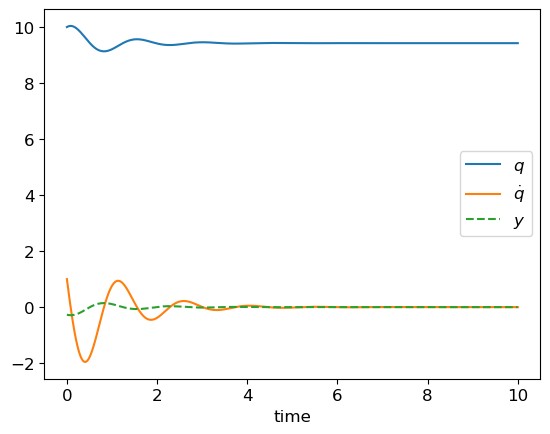

In [61]:
x0 = np.array([10,1])
t = np.linspace(0, 10, 1000)

# Simulate the system
t, y, x = ctrl.input_output_response(nl, t, 0, x0, return_x=True)
q,dq = x

# Plot the response
plt.plot(t, q, label=r'$q$')
plt.plot(t, dq, label=r'$\dot{q}$')
plt.plot(t, y, '--', label=r'$y$')
plt.legend()
plt.xlabel('time')

Note that the simulation diverges from the equilibrium at $(0,0)$ and converges to the equilibrium at $(\pi,0)$.

### equilibrium



The toolbox provides a function to to find an equilibrium near a given state vector.

In [62]:
ueq = 0.
xeq = ctrl.find_eqpt(nl, x0, ueq)
xeq

(array([ 9.425e+00, -9.184e-40]), array([0.]))

Depending on the initial guess that's given, a different equilibrium may be found.

In [63]:
xeq = ctrl.find_eqpt(nl, [np.pi,0], ueq)
xeq

(array([3.142, 0.   ]), array([0.]))

What's happening "under the hood" in this function isn't complicated -- we can reproduce the functionality using a root-finding routine from SciPy's optimization module.

In [65]:
def find_eqpt(nl,x,u=[]):
  from scipy.optimize import root
  f0 = lambda z : nl.updfcn(0,z,u,None)
  res = root(f0,x)
  return res['x']

ueq = 0.
xeq = find_eqpt(nl,x0,ueq)
xeq

array([ 9.425e+00, -9.184e-40])

### linearization

We can linearize about a given equilibrium using the `linearize` tool:

In [67]:
l = ctrl.linearize(nl,xeq,ueq)
print(l)

<LinearIOSystem>: sys[35]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[  0.     1.  ]
     [-19.62  -2.  ]]

B = [[ 0.]
     [-2.]]

C = [[-0.5  0. ]]

D = [[0.]]



The `linearize` tool returns a new system with the $A,B,C,D$ matrices as attributes:

In [68]:
A,B,C,D = l.A,l.B,l.C,l.D
print('A=',A)
print('B=',B)
print('C=',C)
print('D=',D)

A= [[  0.     1.  ]
 [-19.62  -2.  ]]
B= [[ 0.]
 [-2.]]
C= [[-0.5  0. ]]
D= [[0.]]


The matrices obtained from the linearization can be used to define a state-space linear system:

In [69]:
ss = ctrl.ss(A,B,C,D)
print(ss)

<LinearIOSystem>: sys[36]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[  0.     1.  ]
     [-19.62  -2.  ]]

B = [[ 0.]
     [-2.]]

C = [[-0.5  0. ]]

D = [[0.]]



The linear system can then be analyzed using the tools above, e.g. we can generate a Bode plot:

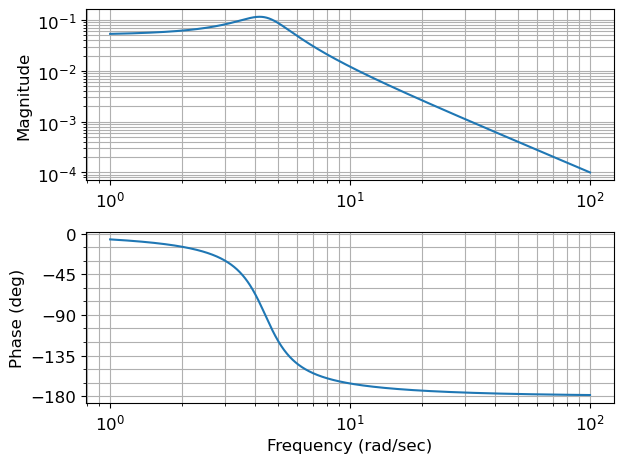

In [70]:
ctrl.bode_plot(ss);
plt.tight_layout()

## interconnection

Continuing with the inverted pendulum from the preceding section,

In [31]:
A = np.array([[ 0., 1.],[19.62, -2.]])
B = np.array([[0], [2]])
C = np.array([[.5, 0]])
D = np.array([[0]])

ss = ctrl.ss(A,B,C,D)

note that the system is unstable because one pole (i.e. eigenvalue) of $A$ has positive real part:

In [32]:
ctrl.pole(ss)

array([ 3.541+0.j, -5.541+0.j])

Fortunately, this system can be stabilized by proportional feedback, as can be seen from the root locus diagram (which shows how the poles of the closed-loop system obtained with $u = - k_P y$ vary as the proportional gain $k_P$ varies):

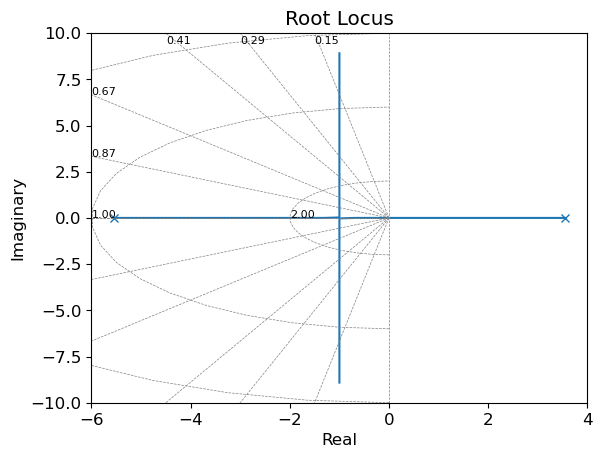

In [33]:
r,k_P = ctrl.root_locus(ss,kvect=np.linspace(0,100,1000),
                        xlim=(-6,4),ylim=(-10,+10));

The diagram indicates that the system ***can*** be stabilized by proportional feebdack (because for sufficiently large gains, both poles have negative real part), so we can check how large $k_P$ needs to be:

In [34]:
print('k_P > %0.1f'%k_P[np.all(r.real < 0,axis=1).nonzero()[0][0]])

k_P > 19.7


And we can verify this calculation by determining the poles (i.e. eigenvalues) of the closed-loop system with gains that are a little larger (real part of all eigenvalues should be negative) and a little smaller (at least one of the eigenvalues should have positive real part).

In [35]:
# too small -- system is unstable
k_P = 19
la.eigvals(A - k_P*np.dot(B,C))

array([ 0.273+0.j, -2.273+0.j])

In [36]:
# large enough -- system is stable
k_P = 20
la.eigvals(A - k_P*np.dot(B,C))

array([-0.213+0.j, -1.787+0.j])

We'll close the loop by creating a proportional controller as a separate system and interconnecting it with the process -- note that the poles of the interconnected system `ctrl.pole(S)` are the same as the eigenvalues of the closed-loop matrix $A - k_PB C$:

In [37]:
P = ss # state-space model defined above
C = ctrl.tf(k_P,1) # transfer function representation of proportional control

# sign = -1 indicates negative feedback
S = ctrl.feedback(P,C,sign=-1)

ctrl.pole(S)

array([-0.213+0.j, -1.787+0.j])

## Nyquist plot

The *Nyquist plot* of a transfer function $L(s)$ is the graph of $L(j\omega)$ in the complex plane:

$$ \Omega = \{ L(j\omega)\in\mathbb{C} : -\infty < \omega < \infty \} $$

For example, consider the third-order transfer function

$$ L(s) = \frac{1}{(s+a)^3} $$

with $a = 0.6$.

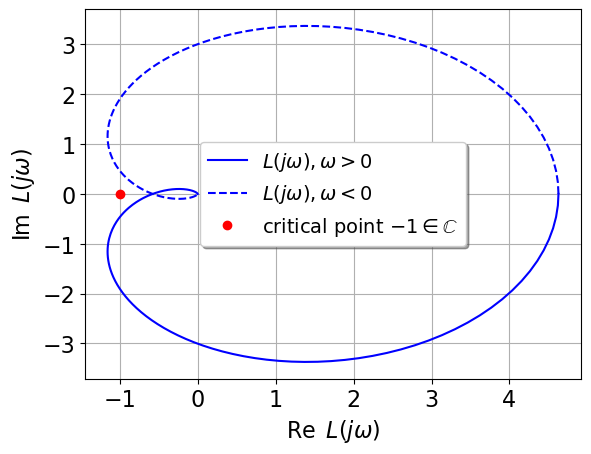

In [38]:
L = lambda s,a=0.6 : 1. / (s + a)**3

# equivalently:

def L(s,a=0.6):
  return 1. / (s + a)**3

omega = np.linspace(0.,1e1,1000)

Omega = L(1.j*omega)

plt.figure()
ax = plt.subplot(1,1,1); ax.grid('on')
ax.plot(Omega.real,Omega.imag,'b-',label=r'$L(j\omega), \omega > 0$')
ax.plot(Omega.real,-Omega.imag,'b--',label=r'$L(j\omega), \omega < 0$')
ax.plot(-1.,0.,'ro',label=r'critical point $-1\in\mathbb{C}$')
ax.legend(fontsize=14,frameon=True,shadow=True)
ax.set_xlabel(r'$\operatorname{Re}\ L(j\omega)$')
ax.set_ylabel(r'$\operatorname{Im}\ L(j\omega)$');

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

Since the graph $\Omega$ of $L(j\omega)$ does not of the *critical point* $-1\in\mathbb{C}$ (and no poles in the right half-plane), the *Nyquist stability criterion (simplified)* implies $\frac{L}{1 + L}$ has no poles in the right half-plane, i.e. is (asymptotically) *stable*.

## Bode and Nyquist plots

For example, consider the third-order transfer function

$$ L(s) = \frac{1}{s(s+1)^2}. $$

The *Bode plot* is the graph of $|L(j\omega)|$ and $\angle L(j\omega)$ as $\omega$ varies between $0$ and $+\infty$ (note that the graph is symmetric for negative $\omega$, so we omit this from the plot).

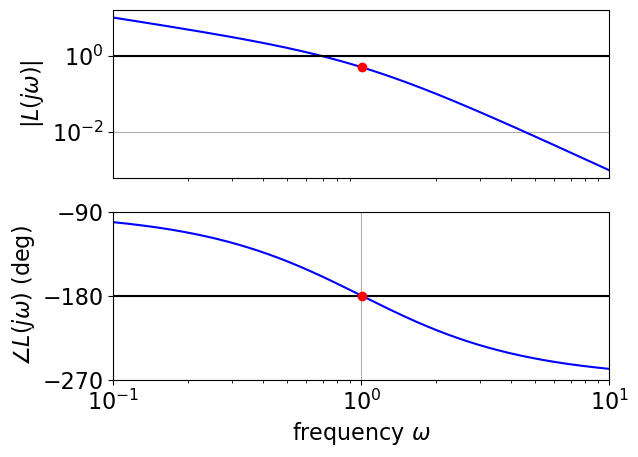

In [39]:
L = lambda s : 1. / (s * (s + 1)**2)

omega = np.logspace(-1,1,1000)
xlim = omega[[0,-1]]

abs_L = np.abs(L(1.j*omega))
angle_L = np.unwrap(np.angle(L(1.j*omega)))*180./np.pi

critical = (angle_L < -180).nonzero()[0][0]

plt.figure(); axs = []
ax = plt.subplot(2,1,1); ax.grid('on')
ax.loglog(omega,abs_L,'b-')
ax.loglog(xlim,[1.,1.],'k-')
ax.loglog(omega[critical],abs_L[critical],'ro')
ax.set_ylabel(r'$|L(j\omega)|$')
ax.set_xticks([])
ax.set_xlim(xlim)
axs.append(ax)

ax = plt.subplot(2,1,2); ax.grid('on')
ax.semilogx(omega,angle_L,'b-')
ax.semilogx(xlim,[-180.,-180.],'k-')
ax.semilogx(omega[critical],angle_L[critical],'ro')
ax.set_xlabel(r'frequency $\omega$')
ax.set_ylabel(r'$\angle L(j\omega)$ (deg)')
ax.set_yticks([-90,-180,-270])
ax.set_xlim(xlim)
axs.append(ax)

for ax in axs:
  for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
               ax.get_xticklabels() + ax.get_yticklabels()):
      item.set_fontsize(16)

Noting that this *Bode plot* simply displays values of $L(j\omega)$ in polar coordinates, it can be transcribed to obtain the *Nyquist plot* of $L(j\omega)$ in the complex plane $\mathbb{C}$:

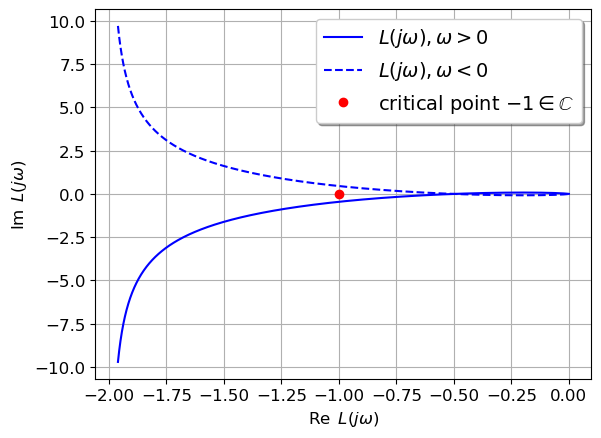

In [40]:
Omega = L(1.j*omega)

plt.figure()
ax = plt.subplot(1,1,1); ax.grid('on')
ax.plot(Omega.real,Omega.imag,'b-',label=r'$L(j\omega), \omega > 0$')
ax.plot(Omega.real,-Omega.imag,'b--',label=r'$L(j\omega), \omega < 0$')
ax.plot(-1.,0.,'ro',label=r'critical point $-1\in\mathbb{C}$')
ax.legend(fontsize=14,frameon=True,shadow=True)
ax.set_xlabel(r'$\operatorname{Re}\ L(j\omega)$')
ax.set_ylabel(r'$\operatorname{Im}\ L(j\omega)$');

## effect of feedback gain

Note that scaling the transfer function by a constant *gain* $k > 0$ simply scales the *Nyquist plot* since

$$ \Omega_{k L} = \{ k L(j\omega) : -\infty < \omega < \infty \} = k \{ L(j\omega) : -\infty < \omega < \infty \} = k\, \Omega_L. $$

This implies that some systems can be stabilized by simply reducing the gain.

In more interesting situations, the system can be stabilized by *increasing* the gain -- consider the following transfer function [AMv2 Ex 10.5]:

$$ L(s) = \frac{3 (s+6)^2}{s(s+1)^2}. $$

The graph $\Omega_L$ has a complicated double--loop on the negative real axis:

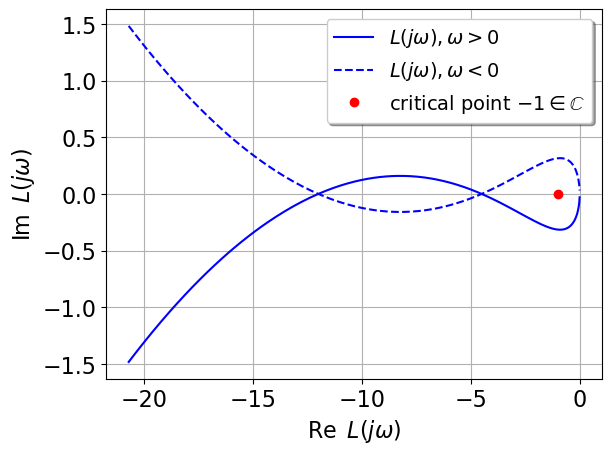

In [41]:
L = lambda s : (3*(s+6.)**2) / (s*(s+1)**2)

omega = np.logspace(0.2,2,1000)

Omega = L(1.j*omega)

plt.figure()
ax = plt.subplot(1,1,1); ax.grid('on')
ax.plot(Omega.real,Omega.imag,'b-',label=r'$L(j\omega), \omega > 0$')
ax.plot(Omega.real,-Omega.imag,'b--',label=r'$L(j\omega), \omega < 0$')
ax.plot(-1.,0.,'ro',label=r'critical point $-1\in\mathbb{C}$')
ax.legend(fontsize=14,frameon=True,shadow=True)
ax.set_xlabel(r'$\operatorname{Re}\ L(j\omega)$')
ax.set_ylabel(r'$\operatorname{Im}\ L(j\omega)$');

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

Note that there are *no (net) encirclements of the critical point $-1\in\mathbb{C}$*, so the *Nyquist stabitility criterion (simplified)* implies that the closed-loop transfer function $\frac{L}{1+L}$ is (asymptotically) *stable*!

Even more counter-intuitive:  the system will become *unstable* if we *decrease* the gain too much, i.e. scale $L$ down by a factor $0 < k < 1$ that is small enough so that the critical point becomes encircled:

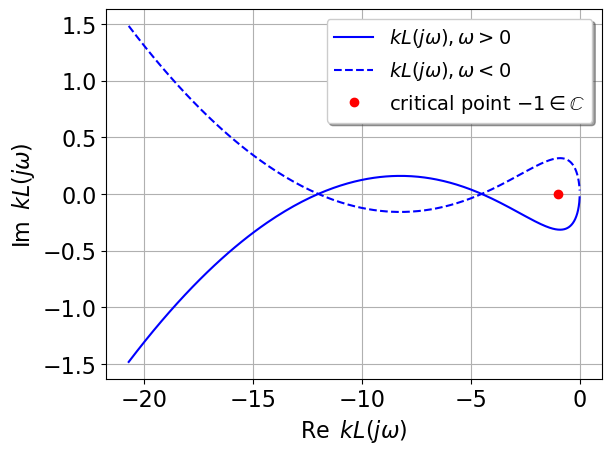

In [42]:
k = 1

Omega_k = k * L(1.j*omega)



plt.figure()
ax = plt.subplot(1,1,1); ax.grid('on')
ax.plot(Omega_k.real,Omega_k.imag,'b-',label=r'$k L(j\omega), \omega > 0$')
ax.plot(Omega_k.real,-Omega_k.imag,'b--',label=r'$k L(j\omega), \omega < 0$')
ax.plot(-1.,0.,'ro',label=r'critical point $-1\in\mathbb{C}$')
ax.legend(fontsize=14,frameon=True,shadow=True)
ax.set_xlabel(r'$\operatorname{Re}\ k L(j\omega)$')
ax.set_ylabel(r'$\operatorname{Im}\ k L(j\omega)$');

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

With $k = 0.125$, the graph of $k L(j\omega)$ encircles the critical point $-1$, so the closed-loop transfer function $\frac{L}{1+L}$ is *unstable*!

## stability margins

Above, we used the *Nyquist plot* to assess *stability* of a closed-loop system, but this plot can also be used to assess *robustness* of the closed-loop system.

There are three frequently-used robustness notions, termed *stability margins*, that we can determine from the *Nyquist plot*:

* *stability margin* $s_m$ = distance from $\Omega$ to $-1\in\mathbb{C}$;
* *gain margin* $g_m$ = smallest increase in gain that causes $\Omega$ to encircle $-1$ (computed as the inverse of distance from $\Omega$ to $-1\in\mathbb{C}$);
* *phase margin* $\varphi_m$ = smallest change in phase that causes $\Omega$ to encircle $-1$ (computed as the distance from $\Omega$ to $-1\in\mathbb{C}$ restricted to rotation of $\Omega$).

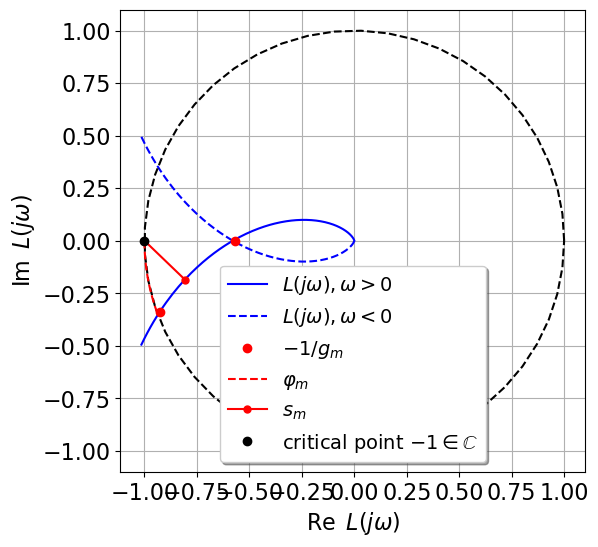

In [43]:
L = lambda s,a=0.6 : 1. / (s + a)**3

omega = np.linspace(0.75,1e1,1000)
Omega = L(1.j*omega)

abs_L = np.abs(Omega)
angle_L = np.unwrap(np.angle(Omega))*180./np.pi

circle = np.exp(1.j*np.linspace(0.,2*np.pi))

# index (i.e. entry) of Omega array corresponding to stability margin
g_m_idx = (angle_L < -180).nonzero()[0][0]
phi_m_idx = np.argmin(np.min(np.abs(Omega - circle[:,np.newaxis]),axis=0))
s_m_idx = np.argmin(np.abs(Omega - (-1.)))

# numerical value of stability margin
g_m = -1./Omega[g_m_idx].real
phi_m = np.angle(Omega[phi_m_idx])*180./np.pi
phi_m_arc = np.exp(1.j*np.linspace(-180,phi_m)*np.pi/180.)
s_m = np.abs(Omega[s_m_idx] - (-1.))

axs = []

plt.figure(figsize=(6,6))
ax = plt.subplot(1,1,1); ax.grid('on'); ax.axis('equal')
# Omega, i.e. graph of L(j omega)
ax.plot(Omega.real,Omega.imag,'b-',label=r'$L(j\omega), \omega > 0$')
ax.plot(Omega.real,-Omega.imag,'b--',label=r'$L(j\omega), \omega < 0$')
# unit circle
ax.plot(circle.real,circle.imag,'k--')
# stability margins
ax.plot(-1./g_m,0.,'ro',label=r'$-1/g_m$')
ax.plot(phi_m_arc.real,phi_m_arc.imag,'r--',label=r'$\varphi_m$')
ax.plot(Omega[phi_m_idx].real,Omega[phi_m_idx].imag,'ro')
ax.plot([-1.,Omega[s_m_idx].real],[0.,Omega[s_m_idx].imag],'r.-',ms=10,label=r'$s_m$')
# critical point (-1. + 0.j)
ax.plot(-1.,0.,'ko',label=r'critical point $-1\in\mathbb{C}$')
# legend and labels
ax.legend(fontsize=14,frameon=True,shadow=True)
ax.set_xlabel(r'$\operatorname{Re}\ L(j\omega)$')
ax.set_ylabel(r'$\operatorname{Im}\ L(j\omega)$');
axs.append(ax)

for ax in axs:
  for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
               ax.get_xticklabels() + ax.get_yticklabels()):
      item.set_fontsize(16)